## Introduction to **earthkit**

**earthkit** is a collection of Python libraries designed to simplify the process of **accessing**, **processing** and **visualising** weather and climate science data.

**earthkit** helps speed up science workflows by providing high-level tools which remove large amounts of the boilerplate code usually required for common tasks.

In this introduction, we are going to use **earthkit-data** to download some ERA5 temperature data from the Copernicus Climate Change Service (C3S) Climate Data Store (CDS), and then **earthkit-maps** to visualise the data on a map.

In [1]:
import earthkit.data
import earthkit.maps

Data in the CDS can be accessed using the earthkit.data.from_source function. For our purposes, this function needs to take three arguments:

- The string `"cds"` - the source of our data;
- The name of the dataset - in our case `"reanalysis-era5-single-levels-monthly-means"`;
- The payload of the request - the parameters we need to pass to access a specific part of the dataset.

Note that you will need a CDS account and a .cdsapirc file in order to have permission to access CDS data. If you have not set this up already, see the [CDS API user guide](https://cds.climate.copernicus.eu/api-how-to).

In [2]:
data = earthkit.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": "1993",
        "month": "12",
        "time": "00:00",
    },
)

Note that we didn't include a `"format"` in our request payload - **earthkit-data** is *format agnostic*, i.e. it should perform in the same way whether you have data in GRIB, netCDF, GeoTIFF or any of a number of other common earth science data formats.

We can inspect the data we have just downloaded in a number of different ways. The most straightforward way is to produce a quick automatic visualisation with the handy `earthkit.maps.quickplot` function:

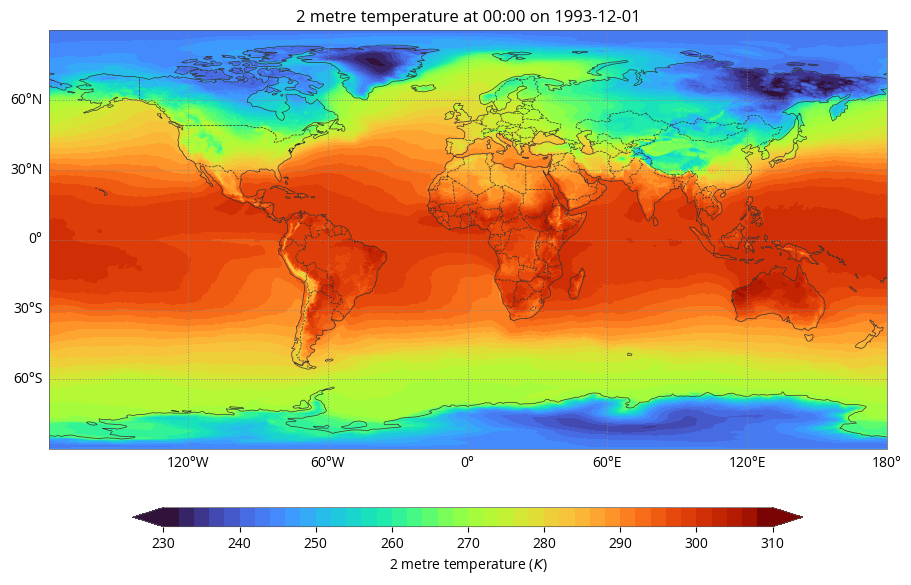

In [ ]:
earthkit.maps.quickplot(data)

Alternatively we can convert the data to a number of well-known data formats, such as an xarray `Dataset`:

In [4]:
data.to_xarray()

<xarray.Dataset>
Dimensions:     (number: 1, time: 1, step: 1, surface: 1, latitude: 721,
                 longitude: 1440)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 1993-12-01
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-28T11:09 GRIB to CDM+CF via cfgrib-0.9.1...

### Customising visualisations

In the example above, **earthkit-maps** made some assumptions about how to visualise the data based on its *metadata*. It correctly identified that the data was 2m temperature, and as such it automatically applied a pre-defined colour palette (or "style") designed specifically for that variable. (Side note: **earthkit-maps** will *not* automatically convert units by default - an automatic style will only be applied if one exists for the specific variable in its specific units).

But what if we want to convert the data to celsius, and show levels ranging from -40 to +40 in steps of 2? We need to define an `earthkit.maps.Style`:

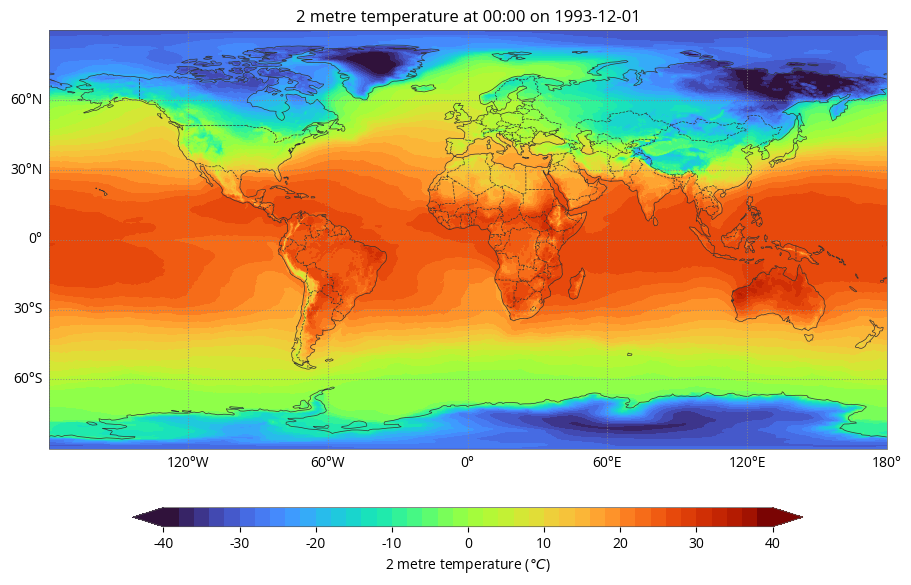

In [5]:
style = earthkit.maps.Style(
    colors="turbo",
    levels=range(-40, 41, 2),
    units="celsius",
    extend="both",
)
earthkit.maps.quickplot(data, style=style)

### The `Chart` class

In the above examples we used `earthkit.maps.quickplot` to produce a quick and convenient visualisation of our data - but what if we want to customise the plot more? We can instantiate an `earthkit.maps.Chart` object to construct our visualisation ourselves.

Let's reproduce the above visualisation on a Robinson map projection. Let's also change the title to something a little bit more informative than the automatic default - note that **earthkit-maps** provides convenient metadata templating in strings, so that you can re-run your scripts on different datasets and still get appropriate titles and labels.

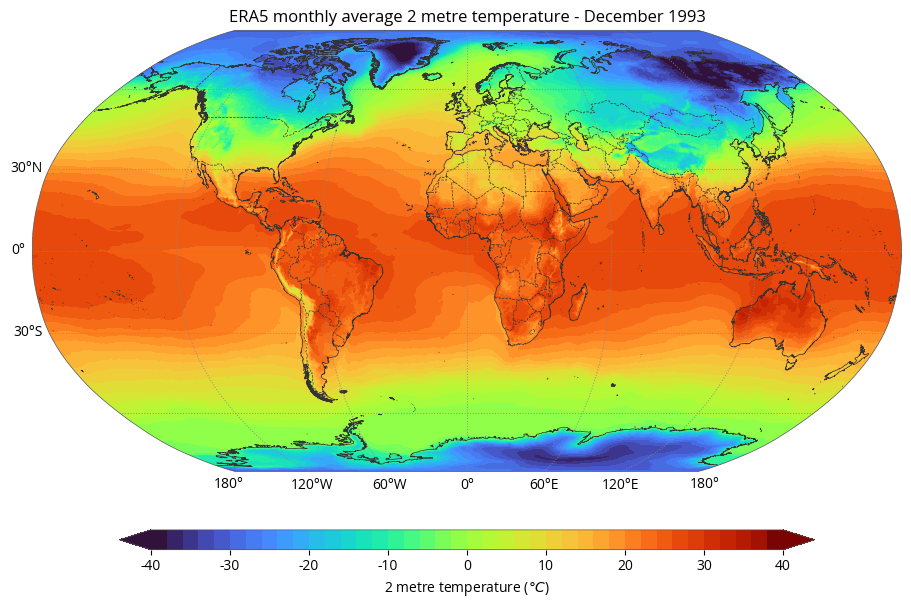

In [6]:
import cartopy.crs as ccrs

chart = earthkit.maps.Chart(crs=ccrs.Robinson())

chart.plot(data, style=style)

chart.coastlines(resolution="high")
chart.gridlines()
chart.borders()

chart.subplot_titles("ERA5 monthly average {variable_name} - {time:%B %Y}")
chart.legend()

chart.show()

Now let's produce the same visualisation over a different domain - Europe. **earthkit-maps** provides powerful automatic domain subsetting based on any* country or continent name, including automatically choosing a suitable map projection (which can of course be overridden if desired).

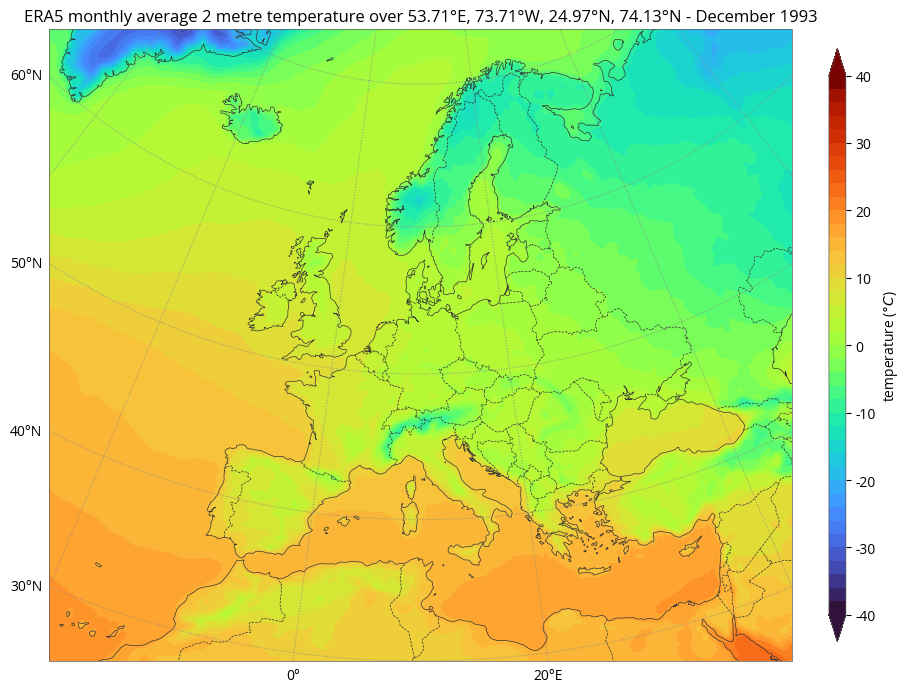

In [7]:
chart = earthkit.maps.Chart(domain=[-20, 40, 30, 72])

chart.plot(data, style=style)

chart.coastlines()
chart.gridlines()
chart.borders()

chart.subplot_titles("ERA5 monthly average {variable_name} over {domain} - {time:%B %Y}")
chart.legend(label="temperature ({units})", location="right")

chart.show()

All of the above techniques can also apply to data containing multiple geospatial "fields" (i.e. time slices, ensemble members etc.). Let's follow the same steps but for data containing 12 time slices - one for each month of the year.

In [8]:
monthly_data = earthkit.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": "1993",
        "month": list(range(1, 13)),
        "time": "00:00",
    },
)

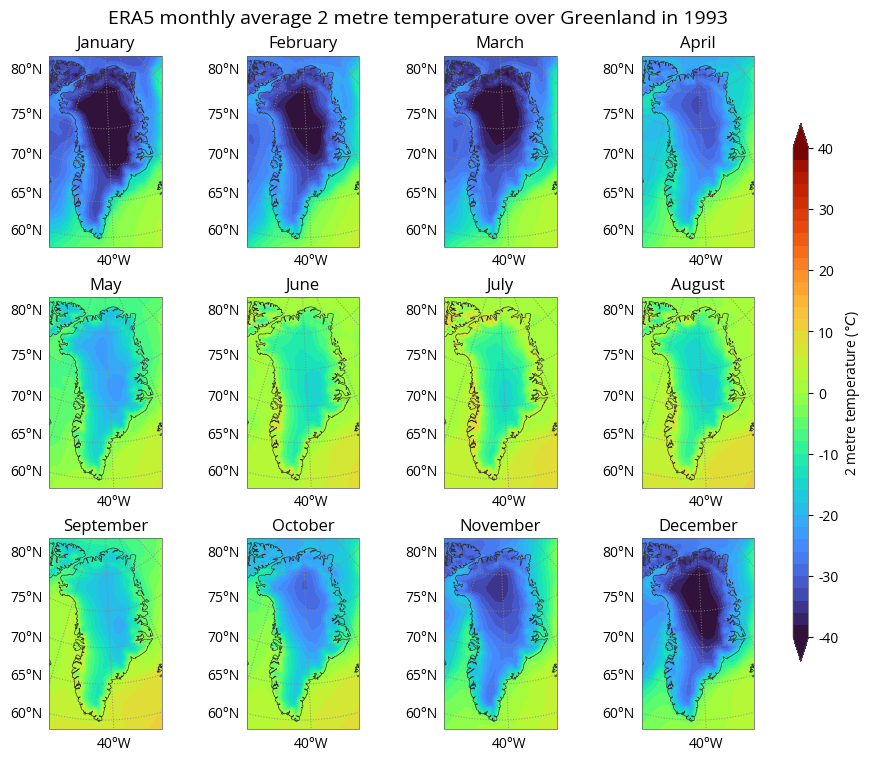

In [9]:
chart = earthkit.maps.Chart(domain="Greenland")

chart.plot(monthly_data, style=style)

chart.coastlines()
chart.gridlines()
chart.borders()

chart.title("ERA5 monthly average {variable_name} over {domain} in {time:%Y}", fontsize=14)
chart.subplot_titles("{time:%B}")
chart.legend(location="right")

chart.show()